# 2. Model Analysis and Comparison

This notebook loads the pre-trained models and evaluates their performance on the test set. It performs the following steps:
1. Loads and preprocesses the same historical data to recreate the exact same test set that the models were not trained on.
2. Loads the trained model objects (`baseline_model.pkl` and `2hl_model.pkl`) from the `../models/` directory.
3. Analysis of the influence of hyper parameters (number of epochs, input timespan)
4. Generates predictions from both models on the training, validation, and test sets.
5. Calculates the final Mean Squared Error (MSE) for each model on each dataset.
6. Visualizes the predictions against the actual values and presents a summary table.

### 2.1 Setup and Data Preparation

The following data preparation steps are consistent with those detailed in the model_training notebook.

##### Import Data from the Data exploration file

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [ ]:
%%capture
from ipynb.fs.full.data_exploration import df_sealevel, GHG_past_comb, df_pred

In [ ]:
# Add src directory to path to import neural_networks module
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from neural_networks import NeuralNetwork_0hl, NeuralNetwork_2hl

# Set random seed for reproducibility
np.random.seed(42)

# Prepare the data for normalization
df_pred = df_pred.rename(columns={'Trend from implemented policies (Lowest bound of  red shading ) ': 'Trend from implemented policies','Limit warming to 2°C (>67%) or return warming to 1.5°C (>50%) after a high overshoot, NDCs until 2030 (Median , dark navy blue line )': 'Limit warming to 2°C or return warming to 1.5°C after a high overshoot', 'Limit warming to 2°C (>67%) (Median , dark green line )': 'Limit warming to 2°C', 'Limit warming to 1.5°C (>50%) with no or limited overshoot ( Median ligh blue line ) ': 'Limit warming to 1.5°C'})
df_sealevel = df_sealevel.groupby(df_sealevel.Day.dt.year).mean()
df_sealevel = df_sealevel.drop('Day', axis=1, errors='ignore')

# Normalization
GHG_past_norm = (GHG_past_comb - GHG_past_comb.mean()) / GHG_past_comb.std()
sealevel_norm = (df_sealevel - df_sealevel.mean()) / df_sealevel.std()

# Sequence and Splitting
def get_GHG_sequence(n_years, df_GHG, start_year, end_year):
    X, y = list(), list()
    for i in range(start_year, end_year + 1):
        end_ix = i - 1
        start_ix = end_ix - n_years + 1
        seq_x = df_GHG.loc[start_ix:end_ix]
        X.append(seq_x.to_numpy())
        y.append(sealevel_norm.loc[i].values)
    return np.array(X), np.array(y)

timespan = 15
train_end_year = 2000
validation_end_year = 2007
test_end_year = 2014

X_train, y_train = get_GHG_sequence(timespan, GHG_past_norm, 1970, train_end_year)
X_val, y_val = get_GHG_sequence(timespan, GHG_past_norm, train_end_year + 1, validation_end_year)
X_test, y_test = get_GHG_sequence(timespan, GHG_past_norm, validation_end_year + 1, test_end_year)

### 2.2 Load Pre-trained Models

In [ ]:
# Load the models from the files
nn_base = NeuralNetwork_0hl.load_model('../models/baseline_model.pkl')
nn_2hl = NeuralNetwork_2hl.load_model('../models/2hl_model.pkl')

print('Models loaded successfully.')

Models loaded successfully.


### 2.3 Analyse the Models

To analyze and improve the performance of our two models, which were initially trained with thoughtfully selected, but assumption-based hyperparameters, we aim to investigate the effect of key hyperparameters on the MSE to potentially mitigate overfitting. The initial number of epochs was set relatively low at 20000, as our training dataset is not particularly large and we sought to avoid overfitting. The hyperparameters of interest  for our analyse are the number of training epochs and the timespan of GHG emission inputs. Each analysis compares the Mean Squared Error (MSE) on the training and validation data for the two-hidden-layer neural network, as a function of the hyperparameter being examined. To reduce the impact of random weight and bias initialization, the MSE was averaged over 100 or 1000 independent training runs, each using a newly initialized network.

### 2.3.1 Prevent overfitting for the single layer neural network

The following overfitting analysis requires significant processing time. To expedite the review process, we have included a pre-generated image of the results below, alongside the code used to perform the analysis.

In [ ]:
np.random.seed()
arr_mse_train_overfit, arr_mse_vali_overfit = [],[]

for n_epochs in np.logspace(4, 6.5, num=20):

    sum_mse_train_overfit, sum_mse_vali_overfit = 0, 0

    for _ in range(100):

        # Train the NN
        nn = NeuralNetwork_0hl(input_size=15, output_size=1)
        mse_train = nn.train(np.squeeze(X_train), y_train.reshape(-1, 1), epochs=int(n_epochs), learningrate = .001, print_output = False)

        # Create predictions for validation set
        pre_vali = nn.predict(np.array([np.squeeze(X_val)]))

        #  Add the MSE (for calculation of the mean)
        sum_mse_vali_overfit += np.mean(np.square(y_val - pre_vali))
        sum_mse_train_overfit += mse_train[-1]

        # Print error message if the MSE doesn't coverge
        if round(mse_train[-1],4) != round(mse_train[-2],4):
            print('Epochs: ' + str(int(n_epochs)) + '    Error: Not enough epochs!')

        # Calculate the mean
    arr_mse_train_overfit += [sum_mse_train_overfit/100]
    arr_mse_vali_overfit += [sum_mse_vali_overfit/100]

    print('Epochs: ' + str(int(n_epochs)) + '   MSE = ' + str(round(arr_mse_train_overfit[-1],4)))

Epochs: 10000    Error: Not enough epochs!
Epochs: 10000   MSE = 0.0158
Epochs: 13538   MSE = 0.0142
Epochs: 18329   MSE = 0.0128
Epochs: 24816   MSE = 0.0119
Epochs: 33598   MSE = 0.011
Epochs: 45487   MSE = 0.0104
Epochs: 61584   MSE = 0.0096
Epochs: 83378   MSE = 0.0091
Epochs: 112883   MSE = 0.0088
Epochs: 152830   MSE = 0.0086
Epochs: 206913   MSE = 0.0084
Epochs: 280135   MSE = 0.0082
Epochs: 379269   MSE = 0.0081
Epochs: 513483   MSE = 0.0081
Epochs: 695192   MSE = 0.008
Epochs: 941204   MSE = 0.008
Epochs: 1274274   MSE = 0.008
Epochs: 1725210   MSE = 0.008
Epochs: 2335721   MSE = 0.008
Epochs: 3162277   MSE = 0.008


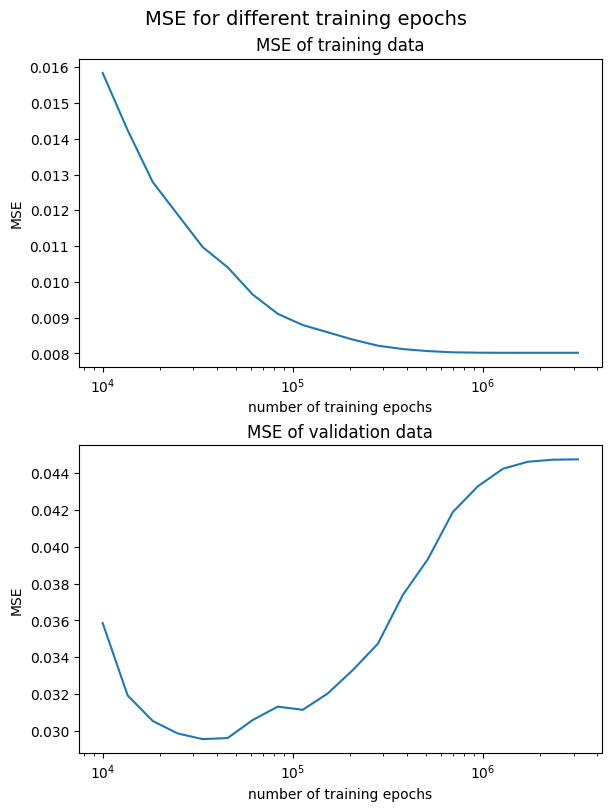

In [ ]:
# Plot the results of the MSE for different epochs
arr_epochs = np.logspace(4, 6.5, num=20)
arr_epochs = arr_epochs.astype(np.int64)
fig=plt.figure(figsize=(6,8),layout='constrained')
fig.suptitle(r'MSE for different training epochs', fontsize=14)
ax1=fig.add_subplot(211)
ax1.plot(arr_epochs,arr_mse_train_overfit)
ax1.set_title(r'MSE of training data')
ax2=fig.add_subplot(212)
ax2.plot(arr_epochs,arr_mse_vali_overfit)
ax2.set_title(r'MSE of validation data')
for ax in [ax1,ax2]:
    ax.set_xscale('log')
    ax.set_xlabel('number of training epochs')
    ax.set_ylabel('MSE')
fig.savefig('images/analysis_training_epochs.png')

In [ ]:
# Pre-generated image of the overfitting analysis
from IPython.display import Image
Image(filename='images/analysis_training_epochs.png')

In [ ]:
print('The number of epochs with the smallest MSE for the validation data is: ' + str(arr_epochs[np.argmin(arr_mse_vali_overfit)]))

The number of epochs with the smallest MSE for the validation data is: 33598


The lowest MSE on the validation data was achieved after training the neural network for approximately 35,000 epochs. The MSE on the training data exhibited an exponential decline over the investigated interval of 10<sup>4</sup> to 10<sup>6.5</sup>, converging to around 0.008. Simultaneously, the MSE on the validation data decreased to a minimum at approximately 35,000 training epochs, after which it began to increase again. This suggests that training beyond this point leads to overfitting, and further increasing the number of epochs is not recommended. Therefore, subsequent analyses will be conducted using a training epoch of 35,000.

### 2.4.2 Analysis of the influence of the input timespan

Similar to the previous analysis, determining the influence of the input timespan requires substantial processing time. To facilitate review, we have again included a pre-generated image of the results alongside the code.

In [ ]:
arr_mse_train, arr_mse_vali = [],[]
y_data = np.array(sealevel_norm.loc[1970:2014])

for timespan in np.arange(10,101,5):

    # Split the data
    X_train_loop, y_train_loop = get_GHG_sequence(timespan, GHG_past_norm, 1970, train_end_year)
    X_vali_loop, y_vali_loop = get_GHG_sequence(timespan, GHG_past_norm, train_end_year + 1, validation_end_year)

    sum_mse_train, sum_mse_vali = 0, 0

    for _ in range(1000):

        # Train the NN
        nn = NeuralNetwork_0hl(input_size=timespan, output_size=1)
        mse_train = nn.train(np.squeeze(X_train_loop), y_train_loop.reshape(-1, 1), epochs=35000, learningrate = .001, print_output = False)

        # Create predictions for validation set
        pre_vali = nn.predict(np.array([np.squeeze(X_vali_loop)]))

        # Add the MSE (for calculation of the mean)
        sum_mse_vali += np.mean(np.square(y_val - pre_vali))
        sum_mse_train += mse_train[-1]

        # Print error message if the MSE doesn't coverge
        if round(mse_train[-1],4) != round(mse_train[-2],4):
            print('Timespan: ' + str(timespan) + ' years:    Error: Not enough epochs!')

    # Calculate the mean
    arr_mse_train += [sum_mse_train/1000]
    arr_mse_vali += [sum_mse_vali/1000]

    print('Timespan: ' + str(timespan) + ' years: MSE = ' + str(round(arr_mse_train[-1],4)))

Timespan: 10 years: MSE = 0.0146
Timespan: 15 years: MSE = 0.011
Timespan: 20 years: MSE = 0.0095
Timespan: 25 years: MSE = 0.0078
Timespan: 30 years: MSE = 0.0076
Timespan: 35 years: MSE = 0.007
Timespan: 40 years: MSE = 0.0069
Timespan: 45 years: MSE = 0.0053
Timespan: 50 years: MSE = 0.0054
Timespan: 55 years: MSE = 0.0049
Timespan: 60 years: MSE = 0.0046
Timespan: 65 years: MSE = 0.0047
Timespan: 70 years: MSE = 0.0045
Timespan: 75 years: MSE = 0.0043
Timespan: 80 years: MSE = 0.0043
Timespan: 85 years: MSE = 0.0042
Timespan: 90 years: MSE = 0.0041
Timespan: 95 years: MSE = 0.0044
Timespan: 100 years: MSE = 0.0041


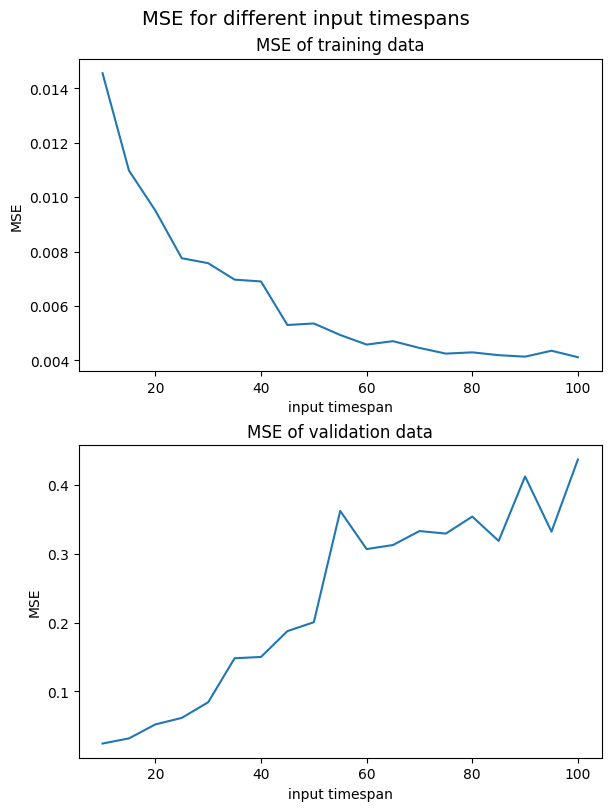

In [ ]:
# Plot the results of the MSE for different input timespans
arr_timespans = np.arange(10,101,5)
fig=plt.figure(figsize=(6,8),layout='constrained')
fig.suptitle(r'MSE for different input timespans', fontsize=14)
ax1=fig.add_subplot(211)
ax1.plot(arr_timespans,arr_mse_train)
ax1.set_title(r'MSE of training data')
ax2=fig.add_subplot(212)
ax2.plot(arr_timespans,arr_mse_vali)
ax2.set_title(r'MSE of validation data')
for ax in [ax1,ax2]:
    ax.set_xlabel('input timespan')
    ax.set_ylabel('MSE')
fig.savefig('images/analysis_input_timespan.png')

In [ ]:
# Pre-generated image of the analysis of the influence of the input timespan
from IPython.display import Image
Image(filename='images/analysis_input_timespan.png')

In [ ]:
print('The input timespan with the smallest MSE for the validation data is: ' + str(arr_timespans[np.argmin(arr_mse_vali)]))

The input timespan with the smallest MSE for the validation data is: 10


Similar to the analysis of the number of training epochs, the analysis of the input timespan revealed an exponential decrease in MSE for the training data over the investigated interval of 10 to 100 years. The MSE of the validation data, however, increases steadily, with the minimum MSE occurring at the beginning of the investigated interval. For this 10-year input timespan, the training data MSE was 0.015, while the validation data MSE was 0.024.

We hypothesize that the two hyperparameters, timespan of GHG emission input and number of training epochs, interact to influence overfitting, as varying the number of training epochs for the analysis of the timespan of GHG emission input resulted in different validation data MSE values. Therefore, an optimal combination of training epochs and input timespan must be identified. For the single-layer neural network, a combination of 35,000 training epochs and a 10-year input timespan appears to be beneficial.

### 2.4.3 Analysis of the number of training epochs for a specific 2 hidden-layer model

We attempted a similar hyperparameter analysis for the neural network with two hidden layers, but the results were more dispersed and less conclusive. This is likely due to the increased sensitivity of the two-hidden-layer network to the initial weights and biases, which are determined randomly. Consequently, the network’s performance is more susceptible to variations in these initial conditions.

However, the general trend – that an excessive number of training epochs and a large timespan of GHG emission inputs can lead to overfitting – remains evident. Due to this dependence on random initialization, we believe it is most effective to prevent overfitting and determine an optimal number of training epochs by analyzing a single, specifically initialized network. We will pursue this approach in the following analysis, acknowledging that the resulting findings may not be fully generalizable.

In [ ]:
arr_mse_train_overfit_2hl, arr_mse_vali_overfit_2hl = [],[]

for n_epochs in np.linspace(10**3, 10**5, num=20):

    # Load model with weights and biases before it was trained and train it
    nn_2hl_old = NeuralNetwork_2hl.load_model('../models/2hl_model_before_training.pkl')
    mse_train = nn_2hl_old.train(np.squeeze(X_train), y_train.reshape(-1, 1), epochs=int(n_epochs), learningrate = .001, print_output = False)

    # Create predictions for validation set
    pre_vali = nn_2hl_old.predict(np.array([np.squeeze(X_val)]))

    # Calculate the mean
    arr_mse_train_overfit_2hl += [mse_train[-1]]
    arr_mse_vali_overfit_2hl += [np.mean(np.square(y_val - pre_vali))]

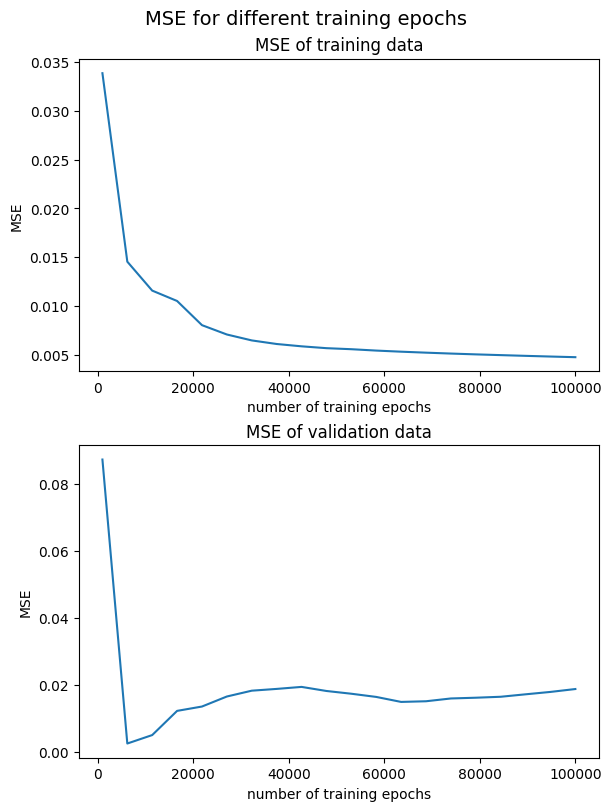

In [ ]:
# Plot the results of the MSE for different epochs
arr_epochs = np.linspace(10**3, 10**5, num=20)
arr_epochs = arr_epochs.astype(np.int64)
fig=plt.figure(figsize=(6,8),layout='constrained')
fig.suptitle(r'MSE for different training epochs', fontsize=14)
ax1=fig.add_subplot(211)
ax1.plot(arr_epochs,arr_mse_train_overfit_2hl)
ax1.set_title(r'MSE of training data')
ax2=fig.add_subplot(212)
ax2.plot(arr_epochs,arr_mse_vali_overfit_2hl)
ax2.set_title(r'MSE of validation data')
for ax in [ax1,ax2]:
    ax.set_xlabel('number of training epochs')
    ax.set_ylabel('MSE')
fig.savefig('images/analysis_training_epochs_2hl_single.png')

In [ ]:
# Pre-generated image of the overfitting analysis
from IPython.display import Image
Image(filename='images/analysis_training_epochs_2hl_single.png')

In [ ]:
print('The number of epochs with the smallest MSE for the validation data is: ' + str(arr_epochs[np.argmin(arr_mse_vali_overfit_2hl)]))

The number of epochs with the smallest MSE for the validation data is: 6210


The lowest MSE on the validation data was achieved after training the neural network for approximately 6000 epochs. The MSE on the training data exhibited an exponential decline over the investigated interval of 10<sup>3</sup> to 10<sup>5</sup>. Simultaneously, the MSE on the validation data decreased to a minimum at approximately 6000 training epochs, after which it began to increase again. This suggests that training beyond this point leads to overfitting, and further increasing the number of epochs is not recommended.

### 2.4.4 Experiment with a dynamic learning rate

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Create new inputs based on the optimized hyperparameters
X_train_new, y_train_new = get_GHG_sequence(10, GHG_past_norm, 1970, train_end_year)
X_val_new, y_val_new = get_GHG_sequence(10, GHG_past_norm, train_end_year + 1, validation_end_year)
X_test_new, y_test_new = get_GHG_sequence(10, GHG_past_norm, validation_end_year + 1, test_end_year)

# Create two baseline models with the same weights and biases
nn_base_new = NeuralNetwork_0hl(input_size=10, output_size=1, dyn_learningrate=False)
nn_base_dyn_learning = NeuralNetwork_0hl(input_size=10, output_size=1, dyn_learningrate=True)
nn_base_dyn_learning.weights = nn_base_new.weights.copy()
nn_base_dyn_learning.bias = nn_base_new.bias.copy()

# Train both models
mse_train_wo_dyn = nn_base_new.train(np.squeeze(X_train_new), y_train_new.reshape(-1, 1), epochs=35000, learningrate = .001, print_output = False)
mse_train_w_dyn = nn_base_dyn_learning.train(np.squeeze(X_train_new), y_train_new.reshape(-1, 1), epochs=35000, learningrate = .001, print_output = False)

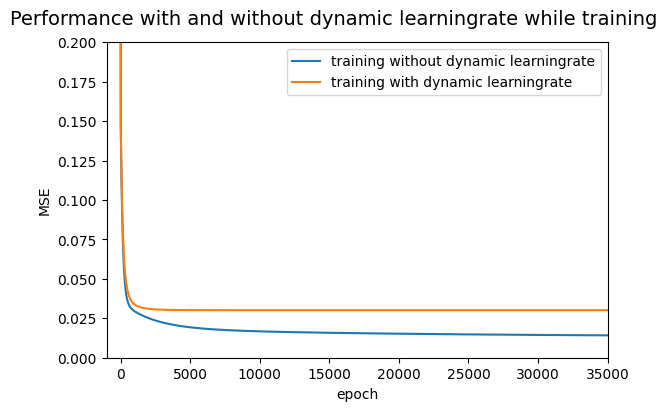

In [ ]:
# Plot the results of the MSE for different epochs
arr_epochs = np.arange(0, 35000)
fig=plt.figure(figsize=(6,4),layout='constrained')
fig.suptitle(r'Performance with and without dynamic learningrate while training', fontsize=14)
ax1=fig.add_subplot(111)
ax1.plot(arr_epochs,mse_train_wo_dyn, label='training without dynamic learningrate')
ax1.plot(arr_epochs,mse_train_w_dyn, label='training with dynamic learningrate')
ax1.set_xlim(-1000, 35000)
ax1.set_ylim(0, .2)
ax1.set_xlabel('epoch')
ax1.set_ylabel('MSE')
ax1.legend()
fig.savefig('images/comparison_dyn_learningrate.png')

This analysis compares the performance of our experiment of a neural network with and without a dynamic learning rate. As shown in the figure, the model trained without a dynamic learning rate consistently achieved a lower MSE during training compared to the model with dynamic learning rate.

This suggests that, for this specific dataset and network architecture, a static learning rate may be more effective. One possible explanation for the poorer performance with dynamic learning rate is that the reduction in learning rate every 100 epochs may have been too aggressive, causing the model to converge prematurely and become stuck in a suboptimal solution. Further investigation with different learning rate decay schedules may be warranted.

### 2.5 Evaluate Models

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Create models with the same initial weights and biases and change the hyperparameters
nn_2hl_new = NeuralNetwork_2hl.load_model('../models/2hl_model_before_training.pkl')
mse_train = nn_2hl_new.train(np.squeeze(X_train), y_train.reshape(-1, 1), epochs=6000, learningrate = .001, print_output = False)
nn_base_new = NeuralNetwork_0hl(input_size=10, output_size=1, dyn_learningrate=False)
mse_train = nn_base_new.train(np.squeeze(X_train_new), y_train_new.reshape(-1, 1), epochs=35000, learningrate = .001, print_output = False)


# Define models and datasets
models_old = {'baseline': nn_base, '2hl': nn_2hl, '2hl_new': nn_2hl_new}
datasets_old = {'train': (X_train, y_train), 'val': (X_val, y_val), 'test': (X_test, y_test)}
models_new = {'baseline_new': nn_base_new}
datasets_new = {'train_new': (X_train_new, y_train_new), 'val_new': (X_val_new, y_val_new), 'test_new': (X_test_new, y_test_new)}

# Generate predictions and calculate MSEs
results = {}
dict_pred = {}
for model_name, model in models_old.items():
    results[model_name] = {}
    for dataset_name, (X, y) in datasets_old.items():
        pred = model.predict(np.squeeze(X))
        if dataset_name == 'test':
            dict_pred[model_name] = pred
        mse = np.mean(np.square(y - pred))
        results[model_name][dataset_name] = mse

for model_name, model in models_new.items():
    results[model_name] = {}
    for dataset_name, (X, y) in datasets_new.items():
        pred = model.predict(np.squeeze(X))
        if dataset_name == 'test_new':
            dict_pred[model_name] = pred
        mse = np.mean(np.square(y - pred))
        results[model_name][dataset_name] = mse

# Print Results
print(f"{'':<25} {'Old hyper parameters':<25} {'New hyper parameters':<25} ")
print('--- Baseline Model ---')
print(f'{'Final MSE (Train): ':<25} {results["baseline"]["train"]:15.4f} {results["baseline_new"]["train_new"]:25.4f}')
print(f'{'Final MSE (Validation): ':<25} {results["baseline"]["val"]:15.4f} {results["baseline_new"]["val_new"]:25.4f}')
print(f'{'Final MSE (Test): ':<25} {results["baseline"]["test"]:15.4f} {results["baseline_new"]["test_new"]:25.4f}')

print('--- 2-Layer Model ---')
print(f'{'Final MSE (Train): ':<25} {results["2hl"]["train"]:15.4f} {results["2hl_new"]["train"]:25.4f}')
print(f'{'Final MSE (Validation): ':<25} {results["2hl"]["val"]:15.4f} {results["2hl_new"]["val"]:25.4f}')
print(f'{'Final MSE (Test): ':<25} {results["2hl"]["test"]:15.4f} {results["2hl_new"]["test"]:25.4f}')

                          Old hyper parameters      New hyper parameters      
--- Baseline Model ---
Final MSE (Train):                 0.0134                    0.0142
Final MSE (Validation):            0.0315                    0.0285
Final MSE (Test):                  0.1777                    0.0418
--- 2-Layer Model ---
Final MSE (Train):                 0.0087                    0.0155
Final MSE (Validation):            0.0126                    0.0055
Final MSE (Test):                  0.0444                    0.0778


The results demonstrate a moderate improvement in the performance of the **baseline model** following hyperparameter optimization. As shown in the table, the neural network trained with the refined hyperparameters exhibits a lower Mean Squared Error (MSE) across the validation and testing datasets compared to the baseline model with initial hyperparameters. Notably, the test MSE decreased substantially from 0.1777 to 0.0418. However, the MSE for the training data slightly increased with hyperparameter optimization.

This suggests the hyperparameter tuning process successfully identified a configuration that better generalizes to unseen data and reduces overfitting. While the improvement is not dramatic, it indicates that careful selection of hyperparameters can contribute to more accurate predictions. It’s important to note that differences in emission input timespans prevented the initialization of identical weights and biases across models, potentially introducing some bias due to the randomization process.

The results of the evaluation for the **two-hidden layer model** show a complex picture. While the hyperparameter optimization led to a significantly reduced validation MSE (0.0055 compared to 0.0126 in the baseline model), the test MSE increased from 0.0444 to 0.0778.

This suggests that the optimized hyperparameters may be causing some overfitting to the validation set. This outcome is likely due to the hyperparameter selection being based on achieving the lowest possible validation MSE, which inadvertently led to the model capturing noise or specific patterns within the validation set that do not generalize to the broader population represented by the test set.

Comparing the performance of the baseline model with hyperparameter optimization and the two-hidden layer model without hyperparameter optimization, the results across all datasets are remarkably similar. The two-hidden layer model exhibits slightly lower training and validation MSE values compared to the baseline model, while the baseline model with optimized hyperparameters demonstrates a marginally better performance on the test set.

This suggests that both models perform comparably, and the choice between them may depend on the specific priorities of the application. The baseline model with optimized hyperparameters provides a slight advantage in generalization, as indicated by its lower test MSE, while the two-hidden layer model appears to fit the training and validation data slightly better

### 2.6 Comparison and Visualization

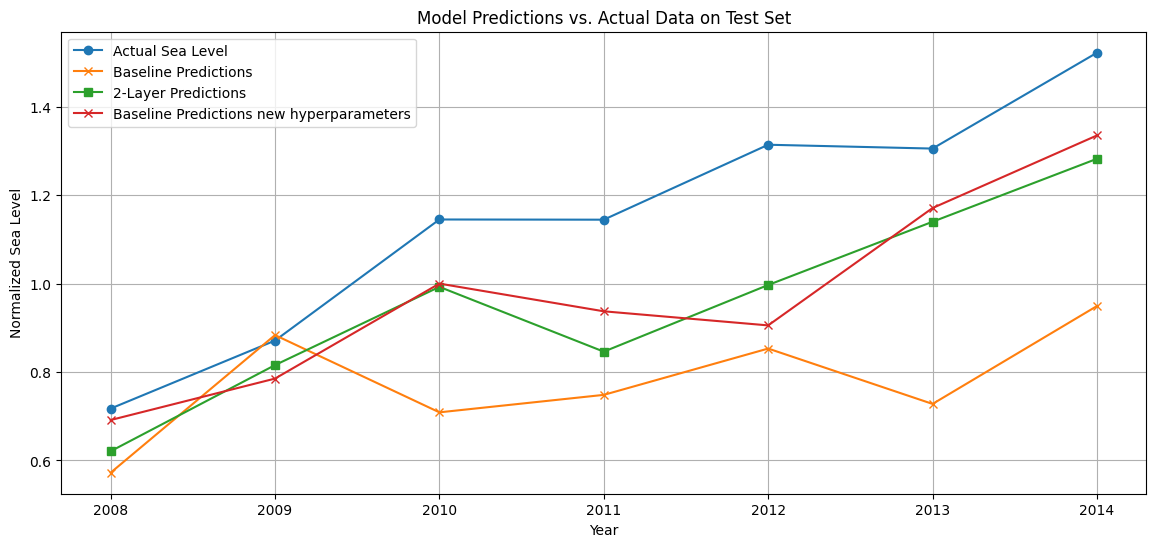

| Model                 |   Train MSE |   Validation MSE |   Test MSE |
|:----------------------|------------:|-----------------:|-----------:|
| Baseline (Linear)     |  0.013378   |       0.0315253  |  0.177703  |
| 2-Hidden-Layer (ReLU) |  0.00868407 |       0.0126038  |  0.0443651 |
| Baseline new hp       |  0.0141812  |       0.0284906  |  0.0417645 |
| 2-Hidden-Layer new hp |  0.0154796  |       0.00550807 |  0.07784   |


In [ ]:
# Plotting predictions vs actuals for the test set
plt.figure(figsize=(14, 6))

test_years = np.arange(validation_end_year + 1, test_end_year + 1)

plt.plot(test_years, y_test, label='Actual Sea Level', marker='o')
plt.plot(test_years, dict_pred['baseline'], label='Baseline Predictions', marker='x')
plt.plot(test_years, dict_pred['2hl'], label='2-Layer Predictions', marker='s')
plt.plot(test_years, dict_pred['baseline_new'], label='Baseline Predictions new hyperparameters', marker='v')

plt.title('Model Predictions vs. Actual Data on Test Set')
plt.xlabel('Year')
plt.ylabel('Normalized Sea Level')
plt.legend()
plt.grid(True)
plt.show()

# Results Table
dict_results = {
    'Model': ['Baseline (Linear)', '2-Hidden-Layer (ReLU)', 'Baseline new hp', '2-Hidden-Layer new hp'],
    'Train MSE': [results['baseline']['train'], results['2hl']['train'],results['baseline_new']['train_new'], results['2hl_new']['train']],
    'Validation MSE': [results['baseline']['val'], results['2hl']['val'],results['baseline_new']['val_new'], results['2hl_new']['val']],
    'Test MSE': [results['baseline']['test'], results['2hl']['test'],results['baseline_new']['test_new'], results['2hl_new']['test']]
}
df_results = pd.DataFrame(dict_results)
print(df_results.to_markdown(index=False))

The curves of the baseline model with hyperparameter optimization and the two-hidden layer model without hyperparameter optimization exhibit a similar trajectory, suggesting a comparable predictive capability. Notably, the standard baseline model demonstrates a particularly poor ability to capture the overall sea level trend, while the optimized baseline and 2-layer models offer marginally improved, though still inaccurate, predictions.

All three models significantly underestimate the sea level rise, indicating a systemic bias in the predictions. While the magnitude of the predicted values is almost consistently lower than the actual data, the models do appear to approximate the general slope of the sea level rise over time. This suggests the models are capturing the direction of the trend, but failing to accurately quantify the magnitude of the change.

A systematic underestimation of sea level severely compromises the predictive abilities of these models. Several factors might contribute to this: a potential bias within the training data itself, an insufficient complexity of the models to fully represent the underlying processes driving sea level rise, or a limitation in the chosen input features. It’s also plausible that the models struggle to account for non-linear accelerations in sea level rise that are not adequately captured by the linear relationships they are learning. Further investigation into the training data, feature engineering, and model architecture is warranted to address this persistent underestimation.

### 2.7 Critique and Next Steps

**Analysis of Results:**

*(This section will be filled in after running the notebook, but we expect to see the 2-layer model outperform the baseline, indicating a non-linear relationship. We will also analyze the gap between training and test MSE to diagnose overfitting.)*

**Discussion of Open Points:**

*   **Overfitting:** If the 2-layer model shows a significantly lower training MSE than test MSE, it's a sign of overfitting. Future iterations should include regularization techniques like L2 regularization (weight decay) or dropout to combat this.
*   **Batch Size:** We are currently using batch gradient descent. Switching to mini-batch gradient descent would be computationally more efficient and could lead to better convergence by escaping local minima.
*   **Hyperparameters:** The architecture (15-8-4-1) was chosen arbitrarily. A systematic hyperparameter search (e.g., using grid search or random search) for the number of layers, number of neurons, learning rate, and epochs is a crucial next step.
*   **Data:** The primary limitation is likely the single-feature input. To build a more powerful model, we must enrich our dataset with more features. Potential candidates include global average temperature, atmospheric CO2 concentrations, and data on volcanic and solar activity. Sourcing this data, for example from NASA's public repositories, would be the most impactful next step.